In [22]:
import networkx as nx
import numpy as np
import torch, time, math
from BoundaryMPS import lattice2D_obc, kacward, BoundaryMPS

In [23]:
torch.set_num_threads(1)
n = 32
graph = nx.grid_2d_graph(n, n)
edges_2d = list(graph.edges)
edges = [(i[0] * n + i[1], j[0] * n + j[1]) for i, j in edges_2d]
L = n
n = n ** 2
edges = np.unique(np.array([sorted(a) for a in edges]), axis=0)

data = []
for gauge in ['self_sqrtm', 'trivial']:
    for Jij, beta in zip(['ferro', 'anti_ferro', 'randn'], [0.44, 0.44, 1.5]):
        print(f'L: {L} interaction: {Jij}, beta: {beta}, gauge: {gauge}')
        if Jij == 'ferro':
            weights = np.ones(len(edges))
        elif Jij == 'rand':
            weights = np.random.rand(len(edges))
        elif Jij == 'randn':
            weights = np.random.randn(len(edges))
        elif Jij == 'sk':
            weights = np.random.randn(len(edges)) / np.sqrt(n)
        elif Jij == 'binary':
            weights = np.random.randint(0, 2, len(edges)) * 2 - 1
        elif Jij == 'anti_ferro':
            weights = -np.ones(len(edges))

        fields = np.zeros(n)

        G = nx.Graph()
        G.add_nodes_from(np.arange(n))
        G.add_edges_from(edges)
        neighbors = []
        for i in range(n):
            neighbors.append(sorted(G.neighbors(i)))
        G_backup = G.copy()

        J = np.zeros([n, n], dtype=np.float64)
        H = torch.tensor(fields, dtype=torch.float64)
        idx = np.array(edges)
        J[idx[:, 0], idx[:, 1]] = weights
        J[idx[:, 1], idx[:, 0]] = weights

        lattice_model = lattice2D_obc(L, torch.from_numpy(J), beta)

        exact_solution = kacward(L, J, beta)
        lnZ_exact = exact_solution.lnZ / L ** 2
        f_exact = -lnZ_exact / beta

        normal_data = []
        threeway_data = []
        fourway_data = []
        for chi in [4, 6, 8, 12, 16, 24, 32, 48]:
            bmps = BoundaryMPS(torch)
            tn = lattice_model.construct_tn(gauge)
            t0 = time.time()
            result, error = bmps(tn, 'normal', chi, 0.0)
            tt = time.time() - t0
            lnZ = (math.log(result[0]) + result[1] * math.log(10)) / n
            f = - lnZ / beta

            bmps = BoundaryMPS(torch)
            tn = lattice_model.construct_tn(gauge)
            t0 = time.time()
            result, error3 = bmps(tn, 'three', chi, 0.0)
            t3 = time.time() - t0
            lnZ3 = (math.log(result[0]) + result[1] * math.log(10)) / n
            f3 = -lnZ3/beta

            tn = lattice_model.construct_tn(gauge)
            t0 = time.time()
            result, error4 = bmps(tn, 'four', chi, 0.0)
            t4 = time.time() - t0
            lnZ4 = (math.log(result[0]) + result[1] * math.log(10)) / n
            f4 = -lnZ4/beta

            # print(f'normal boundary mps, chi {chi}, time {tt:.3g}, free energy error {abs((f-f_exact)/f_exact):.5g}, lnZ error {lnZ-lnZ_exact:.5g}')
            # print(f'threeway boundary mps, chi {chi}, time {t3:.3g}, free energy error {abs((f3-f_exact)/f_exact):.5g}, lnZ error {lnZ3-lnZ_exact:.5g}')
            # print(f'fourway boundary mps, chi {chi}, time {t4:.3g}, free energy error {abs((f4-f_exact)/f_exact):.5g}, lnZ error {lnZ4-lnZ_exact:.5g}')
            normal_data.append((tt, abs((f-f_exact)/f_exact)))
            threeway_data.append((t3, abs((f3-f_exact)/f_exact)))
            fourway_data.append((t4, abs((f4-f_exact)/f_exact)))
        data += [normal_data, threeway_data, fourway_data]

L: 32 interaction: ferro, beta: 0.44, gauge: self_sqrtm
L: 32 interaction: anti_ferro, beta: 0.44, gauge: self_sqrtm
L: 32 interaction: randn, beta: 1.5, gauge: self_sqrtm
L: 32 interaction: ferro, beta: 0.44, gauge: trivial
L: 32 interaction: anti_ferro, beta: 0.44, gauge: trivial
L: 32 interaction: randn, beta: 1.5, gauge: trivial


self_sqrtm ferro 0
self_sqrtm anti_ferro 3
self_sqrtm randn 6
unsplit ferro 9
unsplit anti_ferro 12
unsplit randn 15


/tmp/ipykernel_2740759/527587564.py:19: RuntimeWarning: divide by zero encountered in log10
  axes[i, j].plot([d[0] for d in data[i*3+j*9]], np.log10([d[1] for d in data[i*3+j*9]]), linewidth=2, marker='^',label=f'normal boundary mps {label_appendix[j]} {coupling[i]}', color='tab:orange')
/tmp/ipykernel_2740759/527587564.py:20: RuntimeWarning: divide by zero encountered in log10
  axes[i, j].plot([d[0] for d in data[i*3+j*9+1]], np.log10([d[1] for d in data[i*3+j*9+1]]), linewidth=2, marker='*',label=f'threeway boundary mps {label_appendix[j]} {coupling[i]}', color='b')
/tmp/ipykernel_2740759/527587564.py:23: RuntimeWarning: divide by zero encountered in log10
  axes[i, j].text([d[0] for d in data[i*3+j*9]][k], np.log10([d[1] for d in data[i*3+j*9]])[k], chi[k], fontsize=10, color="tab:orange", weight="light", verticalalignment='bottom', horizontalalignment='left')
/tmp/ipykernel_2740759/527587564.py:24: RuntimeWarning: divide by zero encountered in log10
  axes[i, j].text([d[0] for d 

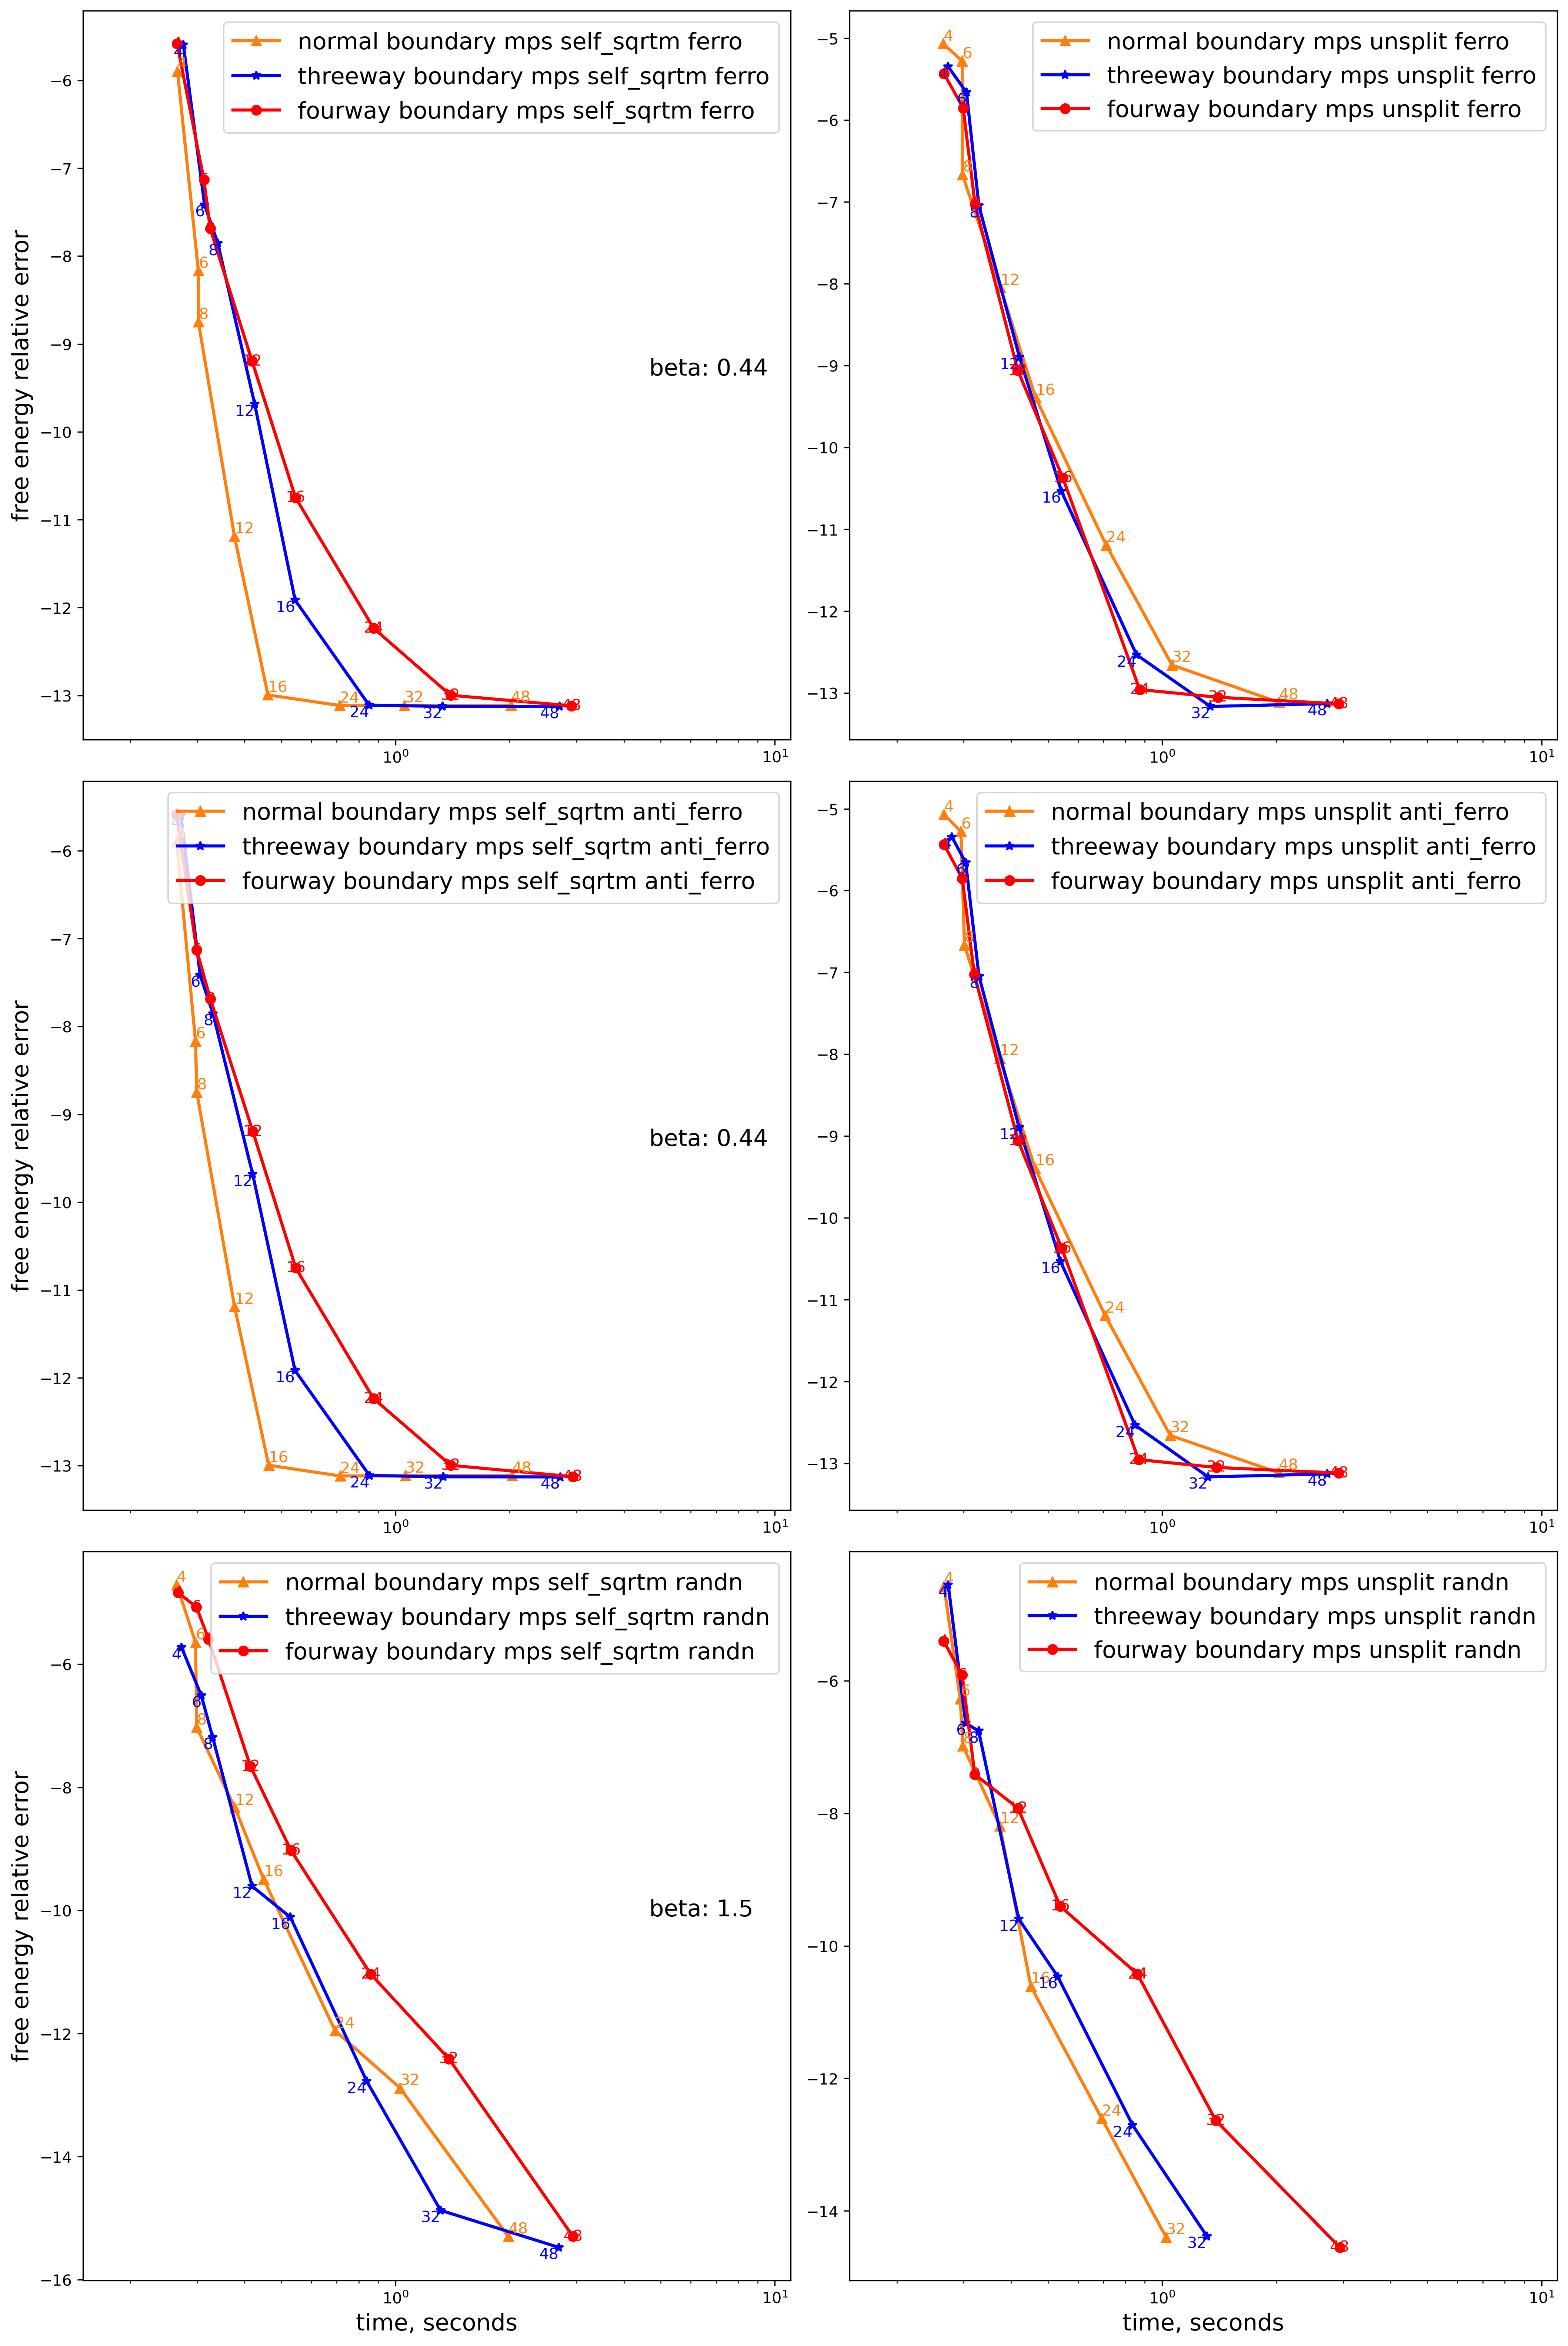

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
chi = [4, 6, 8, 12, 16, 24, 32, 48]
fig, axes = plt.subplots(3, 2, figsize=(14, 21), dpi=300, constrained_layout=True)
coupling = ['ferro', 'anti_ferro', 'randn']
betas = [0.44, 0.44, 1.5]
label_appendix = ['self_sqrtm', 'unsplit']
for j in range(len(label_appendix)):
    for i in range(len(coupling)):
        axes[i, j].set_xscale('log')
        # axes[i, j].set_ylim((-14, -2))
        axes[i, j].set_xlim((0.15, 11))
        if j == 0:
            axes[i, j].set_ylabel('free energy relative error', fontsize=15)
            axes[i, j].text(0.8, 0.5, f'beta: {betas[i]}', size=15, transform=axes[i,j].transAxes)
        if i == len(coupling)-1:
            axes[i, j].set_xlabel('time, seconds', fontsize=15)
        print(f'{label_appendix[j]} {coupling[i]}', i*3+j*9)
        axes[i, j].plot([d[0] for d in data[i*3+j*9]], np.log10([d[1] for d in data[i*3+j*9]]), linewidth=2, marker='^',label=f'normal boundary mps {label_appendix[j]} {coupling[i]}', color='tab:orange')
        axes[i, j].plot([d[0] for d in data[i*3+j*9+1]], np.log10([d[1] for d in data[i*3+j*9+1]]), linewidth=2, marker='*',label=f'threeway boundary mps {label_appendix[j]} {coupling[i]}', color='b')
        axes[i, j].plot([d[0] for d in data[i*3+j*9+2]], np.log10([d[1] for d in data[i*3+j*9+2]]), linewidth=2, marker='o',label=f'fourway boundary mps {label_appendix[j]} {coupling[i]}', color='r')
        for k in range(len(chi)):
            axes[i, j].text([d[0] for d in data[i*3+j*9]][k], np.log10([d[1] for d in data[i*3+j*9]])[k], chi[k], fontsize=10, color="tab:orange", weight="light", verticalalignment='bottom', horizontalalignment='left')
            axes[i, j].text([d[0] for d in data[i*3+j*9+1]][k], np.log10([d[1] for d in data[i*3+j*9+1]])[k], chi[k], fontsize=10, color="b", weight="light", verticalalignment='top', horizontalalignment='right')
            axes[i, j].text([d[0] for d in data[i*3+j*9+2]][k], np.log10([d[1] for d in data[i*3+j*9+2]])[k], chi[k], fontsize=10, color="r", weight="light", verticalalignment='center', horizontalalignment='center')
        axes[i, j].legend(fontsize=15)
plt.show()